In [95]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
data_path = "datos/sample_10e4.json"

from pyspark.sql.functions import dayofweek, dayofmonth, weekofyear, month, year, dayofyear

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from funciones_plot import preprocess_dates, preprocess_ids, plot_analisys_by_year
from funciones_plot import get_random_barrio, get_years, plot_analisys_by_day
from funciones_plot import plot_stats, plot_stats_by_weekends, plot_diferencias_entrada_salida_por_barrios

spark = SparkSession.builder.getOrCreate()
df = spark.read.json(data_path)

### Ideas:
* **Mapear** cuantas salidas y entradas hay en un barrio
* **Posibilidad** estudiarlo como grafo con el groupby de idea3
* **Grafico** L M X J V S D, luego hacer un collect del año entero
* Salidas menos entradas para ver cuantas en uso en barrios, por porcentajes, por barrio.
* **Maxima** cantidad de bici en un momento dado
* **Estudio global:** plot de 12 meses de salidas/ dias y tarta de portentaje de uso global (sumatorio de años) de cada año 
* **Conclusion:** que barrios son los más activos, si ha aumentado el uso
* Anexo de edades

In [96]:
data_geo  = "datos/bases_bicimad.csv"
from pyspark.sql.types import StringType
df_geo    = spark.read.csv(data_geo, header=True)
df_geo    = df_geo.withColumnRenamed('Número', 'plug_station')
df_geo    = df_geo.withColumn('plug_station', sf.col('plug_station').cast(StringType()))
df        = spark.read.json(data_path)
df        = df.withColumn('idplug_station', sf.col('idplug_station').cast(StringType()))
df        = df.withColumn('unplug_hourTime', sf.col('unplug_hourTime').cast(StringType()))
df        = df.withColumn('unplug_hourTime', sf.col('unplug_hourTime').substr(2, 10))

In [97]:
df.limit(5).toPandas()

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code
0,"(59477d642f38430c500d7285,)",4,6,58,2,111,None,390,2017-06-12,f921b9c3fcee0848e18456817e70dd264064669cb7304d...,1,28004
1,"(5b1c52162f3843201c5dee63,)",4,26,90,15,40,"([(Row(coordinates=[-3.68088499972222, 40.4215...",692,2018-06-05,db2ea5a180bddd8486ddabb174fffdd8c774ace726d311...,1,28013
2,"(59e46b0c2f38432040c33521,)",4,24,172,22,136,"([(Row(coordinates=[-3.677193, 40.457155499722...",2055,2017-10-10,2205231ee045b927ff57c58d4ad42f197b89ada6f43d83...,1,28045
3,"(59adcf3b2f38432f98f3685b,)",5,10,109,22,51,"([(Row(coordinates=[-3.68992979972222, 40.4254...",848,2017-08-31,48a8905d6e28ad0f4e4e64cad0b0163e7e932a31725171...,1,28005
4,"(595ccc722f38430f00d48853,)",4,1,101,6,45,"([(Row(coordinates=[-3.6816081, 40.4220885], t...",646,2017-06-28,3848bb88e9c394913370e85948a0ef0d4064e7f7bea177...,1,28004


Vamos a centrar nuestro análisis en los barrios, para ello primero analizaremos un caso concreto

el de **Inserta barrio**

In [98]:
df_barrios = df_geo.select('plug_station', 'Barrio')
df_barrios.printSchema()

root
 |-- plug_station: string (nullable = true)
 |-- Barrio: string (nullable = true)



In [99]:
df_unido_llegadas = df.join(df_barrios, df_barrios.plug_station ==  df.idplug_station,"left")
df_unido_llegadas = df_unido_llegadas.withColumnRenamed('Barrio', 'Barrio_L')

df_unido_salidas  = df.join(df_barrios, df_barrios.plug_station ==  df.idunplug_station,"left")
df_unido_salidas  = df_unido_salidas.withColumnRenamed('Barrio', 'Barrio_S')

In [100]:
df_unido_llegadas.limit(5).toPandas()

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code,plug_station,Barrio_L
0,"(59477d642f38430c500d7285,)",4,6,58,2,111,None,390,2017-06-12,f921b9c3fcee0848e18456817e70dd264064669cb7304d...,1,28004,58,01-04 JUSTICIA
1,"(5b1c52162f3843201c5dee63,)",4,26,90,15,40,"([(Row(coordinates=[-3.68088499972222, 40.4215...",692,2018-06-05,db2ea5a180bddd8486ddabb174fffdd8c774ace726d311...,1,28013,90,04-01 RECOLETOS
2,"(59e46b0c2f38432040c33521,)",4,24,172,22,136,"([(Row(coordinates=[-3.677193, 40.457155499722...",2055,2017-10-10,2205231ee045b927ff57c58d4ad42f197b89ada6f43d83...,1,28045,172,02-06 PALOS DE MOGUER
3,"(59adcf3b2f38432f98f3685b,)",5,10,109,22,51,"([(Row(coordinates=[-3.68992979972222, 40.4254...",848,2017-08-31,48a8905d6e28ad0f4e4e64cad0b0163e7e932a31725171...,1,28005,109,04-06 CASTELLANA
4,"(595ccc722f38430f00d48853,)",4,1,101,6,45,"([(Row(coordinates=[-3.6816081, 40.4220885], t...",646,2017-06-28,3848bb88e9c394913370e85948a0ef0d4064e7f7bea177...,1,28004,101,04-02 GOYA


In [101]:
salidas     = ['idunplug_station', 'unplug_hourTime', 'Barrio_S']
df_salidas  = df_unido_salidas.select(*salidas).groupBy('Barrio_S').count()
df_salidas = df_salidas.withColumnRenamed('count', 'salidas')

llegadas    = ['idplug_station', 'Barrio_L']
df_llegadas = df_unido_llegadas.select(*llegadas).groupBy('Barrio_L').count()
df_llegadas = df_llegadas.withColumnRenamed('count', 'llegadas')

Ahora que tenemos agrupados los datos en una cantidad pequeña , 35, podemos hacer un collect para hacer un plot

In [102]:
df_grafico = df_llegadas.join(df_salidas
                              , df_salidas.Barrio_S ==  df_llegadas.Barrio_L,"left")
df_grafico = df_grafico.select('Barrio_L', 'llegadas', 'salidas')
df_grafico = df_grafico.withColumnRenamed('Barrio_L', 'Barrio')
df_grafico = df_grafico.where(sf.col("Barrio").isNotNull())
df_grafico = df_grafico.orderBy('llegadas')

<AxesSubplot:title={'center':'Visualización de la demanda de las estaciones'}, xlabel='Barrio'>

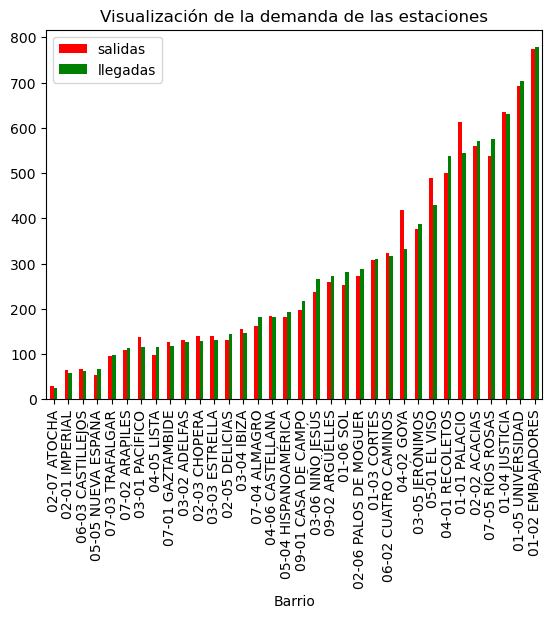

In [103]:
df_grafico.toPandas().plot.bar(
    x     = 'Barrio', 
    y     = ['salidas','llegadas'], 
    color = ['red','green'],
    title = "Visualización de la demanda de las estaciones"
)

### Estudio por años

Solo miro las salidas que es la información que tenemos

In [104]:
df_unido_salidas.limit(2).toPandas()

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code,plug_station,Barrio_S
0,"(59477d642f38430c500d7285,)",4,6,58,2,111,None,390,2017-06-12,f921b9c3fcee0848e18456817e70dd264064669cb7304d...,1,28004,None,None
1,"(5b1c52162f3843201c5dee63,)",4,26,90,15,40,"([(Row(coordinates=[-3.68088499972222, 40.4215...",692,2018-06-05,db2ea5a180bddd8486ddabb174fffdd8c774ace726d311...,1,28013,40,01-02 EMBAJADORES


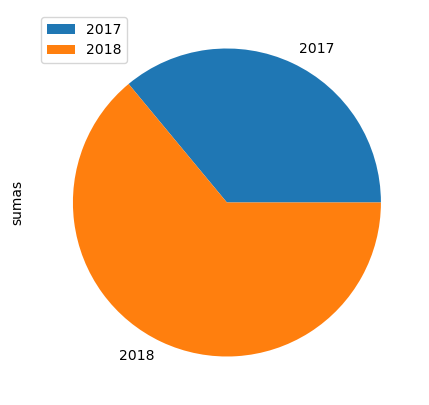

In [105]:
df_year = df.withColumn('unplug_hourTime', sf.col('unplug_hourTime').substr(1, 4))\
            .groupBy('unplug_hourTime')\
            .count()
df_year.limit(5).toPandas()
df_grafico_tarta = pd.DataFrame({'sumas': [3602, 6398]},
                  index=['2017', '2018'])
plot = df_grafico_tarta.plot.pie(y='sumas', figsize=(5, 5))

* Aumento significativo! podemos hacer una comparacion local en barrios

### Pico máximo de uso

In [106]:
df_pico = df_unido_salidas.select(*salidas)\
                        .where(sf.col("Barrio").isNotNull())\
                        .groupBy('unplug_hourTime')\
                        .count()\
                        .agg({'count': 'max'})\
                        .withColumnRenamed('max(count)', 'maximo_diario')
                        

df_pico.toPandas()
# aAhora si 

,maximo_diario
0,44


####  Obs:Hay que poner tambien lo de un barrio en los 7 dias pero hay que tener cuidado de agrupar correctamente los dias de la semana! 

### Analisis por dias

In [107]:
df_original = spark.read.json("datos/sample_10e4.json")

##### Primero preparamos los datos



* Preparacion fechas

In [109]:


df_fechas = df_original.withColumn("dayofweek", dayofweek(df_original.unplug_hourTime.getItem("$date")))\
        .withColumn("dayofyear", dayofyear(df_original.unplug_hourTime.getItem("$date")))\
        .withColumn("weekofyear", weekofyear(df_original.unplug_hourTime.getItem("$date")))\
        .withColumn("year", year(df_original.unplug_hourTime.getItem("$date")))\
        .drop('unplug_hourTime')

* Preparacion ids

In [110]:
data_geo  = "datos/bases_bicimad.csv"
    
# cambiar los ids de las estaciones por el barrio respectivo
df_geo  = spark.read.csv(data_geo, header=True)\
                        .select("Número", "Barrio")\
                            .withColumnRenamed("Número", "idplug_station")\
                            .withColumnRenamed("Barrio", "id_llegadas")
df_geo2 = df_geo.withColumnRenamed("idplug_station", "idunplug_station")\
                            .withColumnRenamed("id_llegadas", "id_salidas")

df_new = df_fechas.join(df_geo, on="idplug_station").join(df_geo2, on="idunplug_station")\
                        .drop("idplug_station", "idunplug_station", "idplug_base", "idunplug_base")
    
# añadir la geolocalización de los barrios
df_geo = spark.read.csv(data_geo, header=True)\
                        .select("Barrio", "Latitud", "Longitud")\
                            .withColumnRenamed("Barrio", "id_salidas")\
                            .withColumnRenamed("Latitud", "Latitud_salidas")\
                            .withColumnRenamed("Longitud", "Longitud_salidas")
    
df_geo2 = df_geo.withColumnRenamed("id_salidas", "id_llegadas")\
                            .withColumnRenamed("Latitud_salidas", "Latitud_llegadas")\
                            .withColumnRenamed("Longitud_salidas", "Longitud_llegadas")
    
df_new = df_new.join(df_geo, on="id_salidas").join(df_geo2, on="id_llegadas")

Ahora que tenemos tratados los datos vamos a ilustrar nuestro análisis

* ¿Cuál ha sido la tendencia de uso por semana en los años del análisis?

# Posible problema ¿Porque en el otro me ha salido mas uso en 2018?

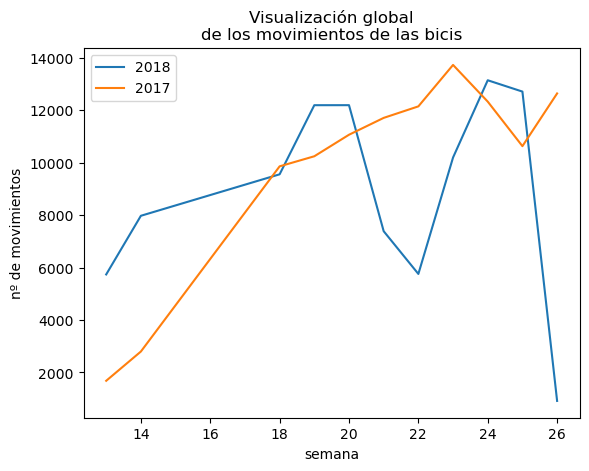

In [111]:
plot_analisys_by_year(df_new)

Nos gustaría estudiar dentro de esta tendencia general 

como se comporta BiciMad dentro de cada semana para ver si podemos encontrar otras tendenciasb

#### Análisis por días de la semana

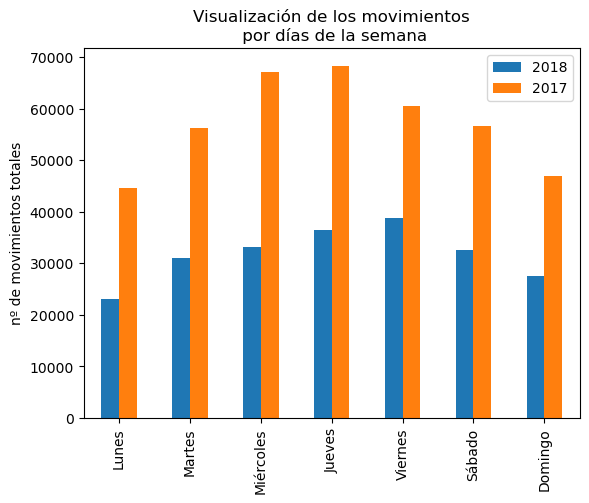

In [112]:
plot_analisys_by_day(df_new, total=True)

Mantiene la tendencia genral vista antes pero además podemos ver un comportamiento creciente hasta que llega
el fin de semana, de forma cíclica

Parece que encontramos gran uniformidad en los datos, hay que tener en cuenta que este es un estudio global, por lo que nos está diciendo que durante todos los días de la semana se usan relativamente igual todas las bicis por Madrid.

Ahora bien, queremos observar por que zonas se mueven más unos días y por qué otras zonas se mueven otros días.


### Visualización de los movimientos semanales de un barrio concreto 

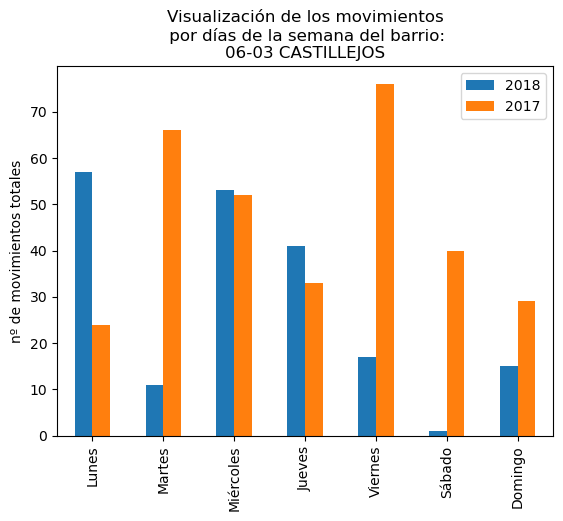

In [113]:
barrio = "06-03 CASTILLEJOS"
plot_analisys_by_day(df_new, barrio)

El pico de uso se desplaza del **viernes en 2017 a lunes en 2018**
Es notable el descenso de uso los sábados, en general el comportamiento de los usuarios ha variado mucho

Esta elección a sido aleatoria. Vamos ahora a buscar estadísticamente barrios interesantes de los que buscar resultados.

### Agrupamos toda la información anterior por barrios, para realizar un análisis global

In [119]:
from matplotlib import pyplot as plt
from pyspark.sql import functions # usaremos -> mean, stddev, max, min, col
from funciones_plot import preprocess_dates, preprocess_ids, plot_analisys_by_year
from funciones_plot import get_random_barrio, get_years, plot_analisys_by_day
from funciones_plot import plot_stats, plot_stats_by_weekends, plot_diferencias_entrada_salida_por_barrios

In [120]:
# Me da error al importarlo, hay que arregarlo
def plot_stats(df):
    # import matplotlib.pyplot as plt
    # import pandas as pd
    # import numpy as np
    years = get_years(df)
    
    # get keys : id - geolocalización
    df_geo = df.select("id_salidas", "Latitud_salidas", "Longitud_salidas").dropDuplicates(["id_salidas"])
    
    # nº de filas = len(years)
    f = len(years)
    
    # nº de columnas = 2 -> una para las gráficas y otro con geolocalizaciones y algún atributo
    c = 2
    
    # crear plot
    fig = plt.figure(figsize=(15,5*f))
    
    for i, year in enumerate(years):
        
        df2 = df.filter(df.year == year).groupBy('id_salidas', 'dayofweek').count().orderBy('id_salidas')

        # Añadir la desviación típica y la media de cada una de las estaciones
        df_stats = df2.groupBy("id_salidas").agg(
                functions.mean("count").alias("mean"), 
                functions.stddev("count").alias('std'),
                functions.min("count").alias('min'),
                functions.max("count").alias('max'),
        ).join(df_geo, "id_salidas", "left").toPandas()
        

        # Cambiar la columna std por la relativa, ya que es la que nos interesa. 
        # Luego multiplicamos por el valor medio máximo para que se aprecien los valores en la 
        # gráfica (los valores reales serán proporcionales a los resultados)
        df_stats["std"] = df_stats["std"] / df_stats["mean"] * df_stats["mean"].max()
        
        # Columna con las diferencias (relativas) máximo - mínimo
        df_stats["dif"] = (df_stats["max"] - df_stats["min"]) / df_stats["mean"]
        
        maximo_std = df_stats[df_stats["std"] == df_stats["std"].max()]
        maximo_dif = df_stats[df_stats["dif"] == df_stats["dif"].max()]

        # PLOT IZQUIERDO
        # --------------
        # Tendremos:
        #  - BarPlot de los valores medios (en gris transparente para después aprecias las std)
        #  - LinePlot de las std (relativa) en rojo
        #  - ScatterPlot del valor máximo de : relative std -> para después analizarlo
        
        ax = fig.add_subplot(f, c, 2*i + 1)

        n = df_stats.shape[0]
        x = range(n)
        
        ax.plot(x, df_stats["std"].values, "m-", label="std")
        ax.bar(x, df_stats["mean"].values, color="grey", alpha=0.8, label="mean")
        ax.bar(maximo_std.index[0], maximo_std["mean"].values[0], 
                   color="m", label="max std: " + str(maximo_std["id_salidas"].values[0]))
        ax.bar(maximo_dif.index[0], maximo_dif["mean"].values[0], 
                    color="red", label="max dif: " + str(maximo_dif["id_salidas"].values[0]))
        ax.legend()
        ax.set_xlabel("Barrios")
        ax.set_ylabel("Usos de las bicis")
        ax.set_xticks([])
        ax.set_title(f"Datos estadísticos sobre los barrios\n--{year}--")

        
        # PLOT DERECHO
        # ------------
        # Tendremos un plot con las geolocalizaciones con los siguientes datos implícitos:
        #  - Tamaño del punto: indica el la media de uso en esa zona (cuanto más grande más uso)
        #  - Color: también se clasifican por la media de uso (los mismas colores indican mismas medias)

        ax = fig.add_subplot(f, c, 2*i + 2)
        
        
        df_stats.Latitud_salidas = df_stats.Latitud_salidas.astype("float64")
        df_stats.Longitud_salidas = df_stats.Longitud_salidas.astype("float64")
                
        ax.scatter(
            x = df_stats["Latitud_salidas"],
            y = df_stats["Longitud_salidas"],
            c = df_stats["mean"],
            s = df_stats["mean"],
            alpha = 0.8
        )
        ax.set_xlabel("Latitud")
        ax.set_ylabel("Longitud")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Datos geográficos sobre los barrios\n--{year}--")

        
    
    plt.show()

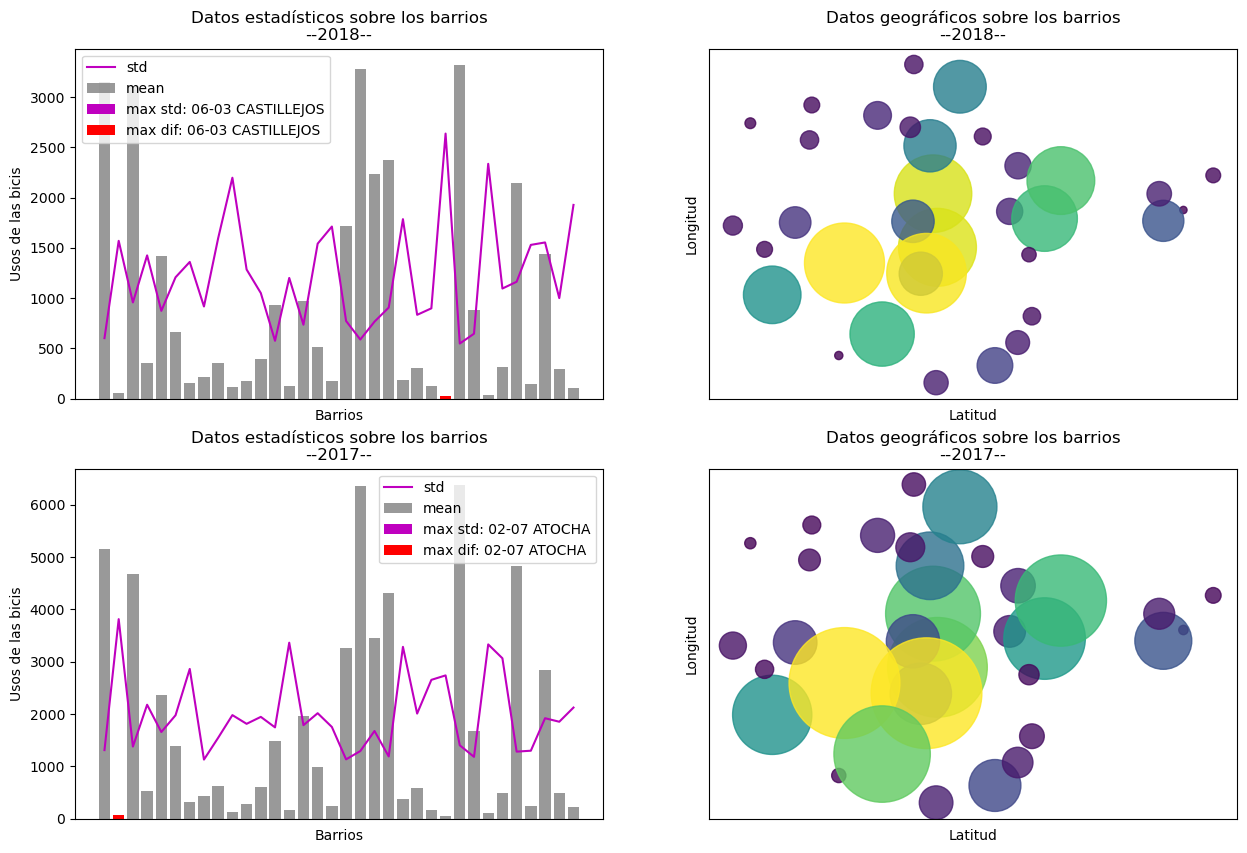

In [122]:
plot_stats(df_new)

De media, observamos mayores movimientos por el centro (los puntos amarillos) mientras que a las afueras menor uso de las bicicletas. Esto se puede deber a que disponen de más puntos donde usarlas

Parece interesante estudiar su comportamiento separando los dias de entre semana de los fines de semana

### Vamos a analizar los datos diarios de los barrios que nos han dado mayores desviaciones típicas y diferencia

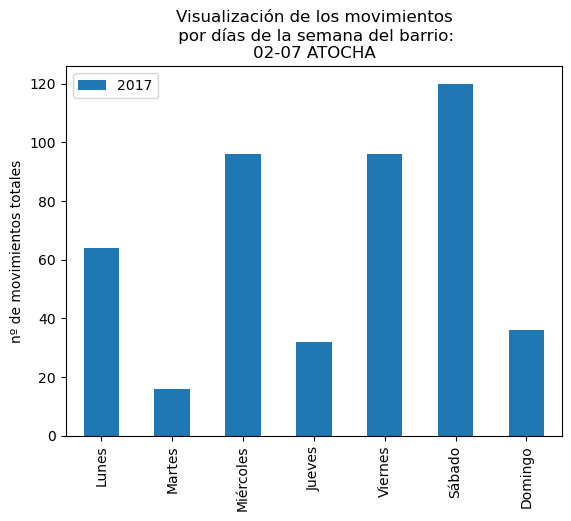

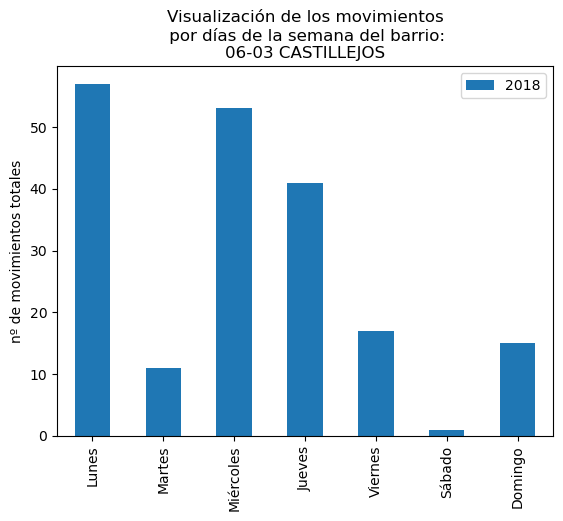

In [123]:
barrio_2017 = "02-07 ATOCHA"
barrio_2018 = "06-03 CASTILLEJOS"

plot_analisys_by_day(df_new, barrio_2017, years=["2017"])
plot_analisys_by_day(df_new, barrio_2018, years=["2018"])

 - Año 2017:
 
  - **02-07 ATOCHA**: se observa una diferencia considerable en los días viernes y sabado, es decir, durante la llegada del fin de semana es una zona bastante transitada a diferencia de los demás días de la semana.

 - Año 2018:
  
  - **06-03 CASTILLEJOS**: Se observa un claro descenso a lo largo del transcurso de la semana. Dejando los fines de semana casi inactivos en comparación con los días laborales.


Es interesante ver que los martes es un mínimo en los días laborales en dos barrios con comportamientos muy opuestos

### Estudio separado de días laborables y no laborables

 - Entre semana: Lunes, ..., Viernes
 - Fin de semana: Viernes, Sábado, Domingo

* De esta forma tendremos una perspectiva más correcta de como son los ciclos semanales

In [127]:
from matplotlib import pyplot as plt

plot_stats_by_weekends(df_new)
# Da el mismo error que la otra luego lo solucionamos

NameError: name 'plt' is not defined

Observamos que las tendencias son similares, realizamos un estudio por estaciones para ver si podemos encontrar diferencias significativas, de forma que en función de la estacón el camión que repone las bicicletas debería seguir un camino u otro.

### Estudio por estaciones